In [ ]:
# Uncomment for Google Drive integration
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


**COMP 562 Final Project - Analysis of Stocks and Sectors**

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.neural_network import MLPClassifier

##################
# Financial Data #
##################
# Load data - change this path to where the financial_data.csv file can be found on your drive
# financial_data = pd.read_csv('/content/drive/MyDrive/COMP 562 Final Project/financial_data.csv')
financial_data = pd.read_csv('/data/financial_data.csv')


**Define Training, Test Sets**

In [ ]:
test_set = pd.DataFrame()
train_set = pd.DataFrame()

# Get indices of each sector to segment test, train sets
sectors = financial_data.Sector_y.unique()
for sector in sectors:
  test_set = test_set.append(financial_data.iloc[financial_data.index[financial_data['Sector_y'] == sector].tolist()[:2]], ignore_index=True)
  train_set = train_set.append(financial_data.iloc[financial_data.index[financial_data['Sector_y'] == sector].tolist()[2:]], ignore_index=True)

X_train, X_test = train_set._get_numeric_data(), test_set._get_numeric_data()
x_cols = X_train.columns
y_train, y_test = train_set[['Symbol', 'Name', 'Sector_y']], test_set[['Symbol', 'Name', 'Sector_y']]
y_labels = y_test

# Scale the input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=x_cols).fillna(0)
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns=x_cols).fillna(0)

# Assign numeric values to sector labels
sector_map = {}
for i in range(len(sectors)):
  sector_map[sectors[i]] = i
y_train = [sector_map[sector] for sector in y_train.Sector_y]
y_test = [sector_map[sector] for sector in y_test.Sector_y]

print(f"Sector Label Map: {sector_map}")
print(f"Number of Parameters: {len(x_cols)}")
print(f"Training Set Size: {len(X_train)}, Test Set Size: {len(X_test)}")
print()

Sector Label Map: {'Industrials': 0, 'Healthcare': 1, 'Technology': 2, 'Consumer Cyclical': 3, 'Utilities': 4, 'Financial Services': 5, 'Basic Materials': 6, 'Real Estate': 7, 'Consumer Defensive': 8, 'Communication Services': 9, 'Energy': 10}
Number of Parameters: 250
Training Set Size: 443, Test Set Size: 22



/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [ ]:
###############################
#    Fit model to the data    #
###############################
#   - X: ndarray of shape (n_samples, n_features)
#   - y: ndarray of shape (n_samples,)

def train_classifier_alpha(X_train, y_train, alpha_):
  tempClassifier = MLPClassifier(hidden_layer_sizes=(50, 50), activation='tanh', solver='adam', alpha=alpha_, learning_rate='constant', learning_rate_init=.001, momentum=.9, max_iter=5000)
  tempClassifier.fit(X_train, y_train)
  return tempClassifier
def train_classifier_lr(X_train, y_train, lr):
  tempClassifier = MLPClassifier(hidden_layer_sizes=(50, 50), activation='tanh', solver='adam', alpha=.001, learning_rate='constant', learning_rate_init=lr, momentum=.9, max_iter=5000)
  tempClassifier.fit(X_train, y_train)
  return tempClassifier


**Cross-Validation | No PCA**

In [ ]:
###################################
#    Cross-Validation - No PCA    #
###################################
import numpy as np
from sklearn.model_selection import StratifiedKFold

num_folds = 4
training_folds = StratifiedKFold(n_splits=num_folds)

# Define hyperparameter values we are trying to optimize
alpha_list = [.01, .001, .005, .0001, .0005]
learning_rate_list = [.01, .001, .005, .0001, .0005]

# Convert y data from list to np.array for easier indexing
y_train = np.array(y_train)

alphaError = []
lrError = []
# Iterate over alphas
for i in range(len(alpha_list)):
#for lr in learning_rate_list:
  CVAlphaError = 0
  CVLRError = 0
  # For each alpha, train on each fold
  for train_index, test_index in training_folds.split(X_train, y_train) :
    X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

    # Train temp classifiers
    alphaClassifier = train_classifier_alpha(X_fold_train, y_fold_train, alpha_list[i])
    lrClassifier = train_classifier_lr(X_fold_train, y_fold_train, learning_rate_list[i])

    # Score classifiers
    test_score_lr = lrClassifier.score(X_fold_test, y_fold_test)
    test_score_alpha = alphaClassifier.score(X_fold_test, y_fold_test)

    CVAlphaError += 1-test_score_alpha
    CVLRError += 1-test_score_lr

  # Update error vectors
  CVAlphaError = CVAlphaError/num_folds
  CVLRError = CVLRError/num_folds
  alphaError.append(CVAlphaError)
  lrError.append(CVLRError)
  print(f"CVError (alpha={alpha_list[i]}): {CVAlphaError}")
  print(f"CVError (learning_rate={learning_rate_list[i]}): {CVLRError}")
  print()



CVError (alpha=0.01): 0.42205159705159706
CVError (learning_rate=0.01): 0.41287878787878785

CVError (alpha=0.001): 0.40395167895167894
CVError (learning_rate=0.001): 0.38359950859950864

CVError (alpha=0.005): 0.4355446355446355
CVError (learning_rate=0.005): 0.3972153972153972

CVError (alpha=0.0001): 0.4016994266994267
CVError (learning_rate=0.0001): 0.41973791973791974

CVError (alpha=0.0005): 0.4175470925470925
CVError (learning_rate=0.0005): 0.3904176904176904



**Show CV Analysis (non-PCA)**

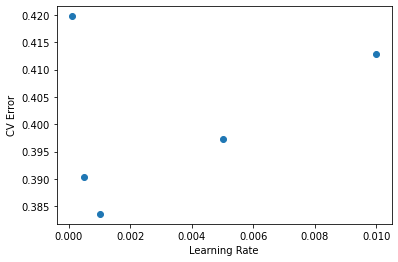

Min Learning Rate: 0.001


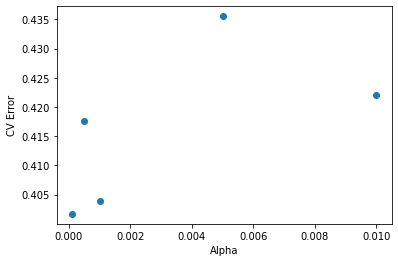

Min Alpha: 0.0001


In [ ]:
import matplotlib.pyplot as plt
plt.plot(learning_rate_list, lrError, 'o')
plt.xlabel('Learning Rate')
plt.ylabel('CV Error')
plt.show()

print(f"Min Learning Rate: {learning_rate_list[np.argmin(lrError)]}")

plt.plot(learning_rate_list, alphaError, 'o')
plt.xlabel('Alpha')
plt.ylabel('CV Error')
plt.show()
print(f"Min Alpha: {alpha_list[np.argmin(alphaError)]}")

**Train and Evaluate Final Non-PCA Model**

In [ ]:
from sklearn.neural_network import MLPClassifier

#############################
#    Define NN structure    #
#############################
#   - hidden_layer_sizes = tuple, element represents the number of neurons in the ith hidden layer
#   - activation = activation function for the hidden layer | options we are interested in are {'relu', 'logistic', 'tanh'}
#   - solver = solver for weight optimization | options are {'lbfgs', 'sgd', 'adam'}, sgd is stochastic gradient descent. Apparently for small datasets lbfgs works best
#   - alpha = regularization parameter, default = .0001
#   - learning_rate = learning rate schedule for weight updates | options are {'constant', 'invscaling', 'adaptive'}
#   - learning_rate_init = initial learning rate used | only used for 'sgd' and 'adam' optimizers
#   - max_iter = maximum number of training iterations, unless earlier convergence
#   - momentum = Momentum for SGD update, only used for 'sgd' optimizer, default=.9

sectorClassifier = MLPClassifier(hidden_layer_sizes=(50, 50), activation='tanh', solver='adam', alpha=.0001, learning_rate='constant', learning_rate_init=.001, max_iter=250)

sectorClassifier.fit(X_train, y_train)
print("Training set score: %f" % sectorClassifier.score(X_train, y_train))
print("Test set score: %f" % sectorClassifier.score(X_test, y_test))




Training set score: 1.000000
Test set score: 0.681818


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


**Analyze Incorrect Classifications**

A.O. Smith Corp
Predicted Sector: Technology (2)
Actual Sector: Industrials (0)


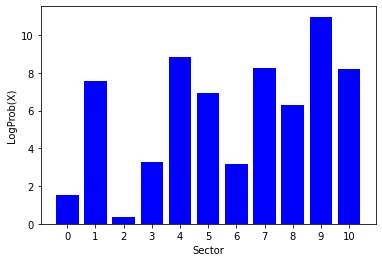

Abbott Laboratories
Predicted Sector: Technology (2)
Actual Sector: Healthcare (1)


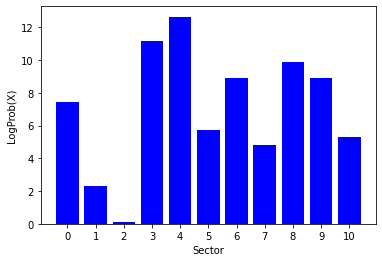

AbbVie Inc.
Predicted Sector: Financial Services (5)
Actual Sector: Healthcare (1)


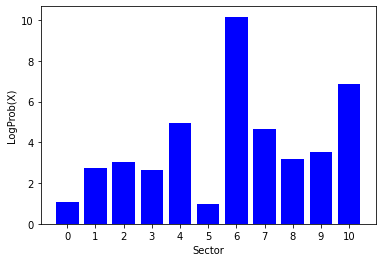

Advance Auto Parts
Predicted Sector: Healthcare (1)
Actual Sector: Consumer Cyclical (3)


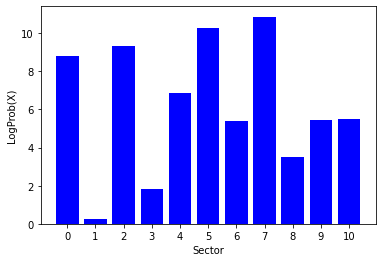

AES Corp
Predicted Sector: Consumer Cyclical (3)
Actual Sector: Utilities (4)


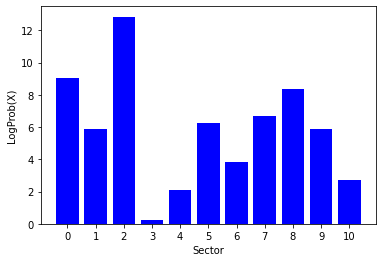

Air Products & Chemicals Inc
Predicted Sector: Technology (2)
Actual Sector: Basic Materials (6)


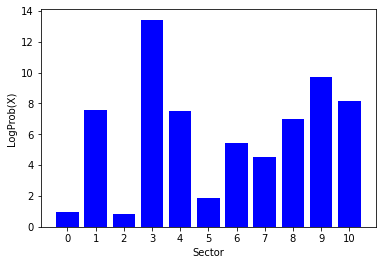

Altria Group Inc
Predicted Sector: Industrials (0)
Actual Sector: Consumer Defensive (8)


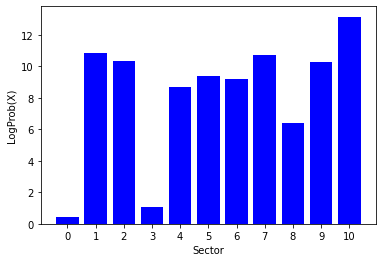

In [ ]:
sector_map_reverse = {y:x for x,y in sector_map.items()}

for i in range(len(y_test)):
  prediction = sectorClassifier.predict([X_test.iloc[i]])[0]
  log_probs = sectorClassifier.predict_log_proba([X_test.iloc[i]])
  true_sector = y_test[i]
  if prediction != true_sector:
    print(f"{y_labels.iloc[i].Name}")
    print(f"Predicted Sector: {sector_map_reverse[prediction]} ({prediction})")
    print(f"Actual Sector: {sector_map_reverse[true_sector]} ({true_sector})")
    plt.bar(range(len(sector_map.items())), -1*log_probs[0], color='blue')
    plt.xticks(range(len(sector_map.items())))
    plt.xlabel('Sector')
    plt.ylabel('LogProb(X)')
    plt.show()


**Implement PCA**

In [ ]:
from sklearn.decomposition import PCA

# Number of components derived from results of clustering analysis
pca = PCA(n_components=10)
pcs_train = pca.fit_transform(X_train)
pcs_test = pca.fit_transform(X_test)

PCA_X_train = pd.DataFrame(pcs_train)
PCA_X_test = pd.DataFrame(pcs_test)

**Cross Validation | w/ PCA**

In [ ]:
###################################
#    Cross-Validation - w/ PCA    #
###################################
import numpy as np
from sklearn.model_selection import StratifiedKFold

num_folds = 4
training_folds = StratifiedKFold(n_splits=num_folds)

# Define hyperparameter values we are trying to optimize
alpha_list = [.01, .001, .005, .0001, .0005]
learning_rate_list = [.01, .001, .005, .0001, .0005]

# Convert y data from list to np.array for easier indexing
y_train = np.array(y_train)
y_test = np.array(y_test)

alphaError = []
lrError = []
# Iterate over alphas
for i in range(len(alpha_list)):
#for lr in learning_rate_list:
  CVAlphaError = 0
  CVLRError = 0
  # For each alpha, train on each fold
  for train_index, test_index in training_folds.split(PCA_X_train, y_train) :
    X_fold_train, X_fold_test = PCA_X_train.iloc[train_index], PCA_X_train.iloc[test_index]
    y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

    # Train temp classifiers
    alphaClassifier = train_classifier_alpha(X_fold_train, y_fold_train, alpha_list[i])
    lrClassifier = train_classifier_lr(X_fold_train, y_fold_train, learning_rate_list[i])

    # Score trained classifiers
    test_score_lr = lrClassifier.score(X_fold_test, y_fold_test)
    test_score_alpha = alphaClassifier.score(X_fold_test, y_fold_test)

    CVAlphaError += 1-test_score_alpha
    CVLRError += 1-test_score_lr
    
  # Update error vectors  
  CVAlphaError = CVAlphaError/num_folds
  CVLRError = CVLRError/num_folds
  alphaError.append(CVAlphaError)
  lrError.append(CVLRError)
  print(f"CVError (alpha={alpha_list[i]}): {CVAlphaError}")
  print(f"CVError (learning_rate={learning_rate_list[i]}): {CVLRError}")
  print()

CVError (alpha=0.01): 0.5144963144963145
CVError (learning_rate=0.01): 0.4919533169533169

CVError (alpha=0.001): 0.5078009828009828
CVError (learning_rate=0.001): 0.4920966420966421

CVError (alpha=0.005): 0.50999180999181
CVError (learning_rate=0.005): 0.4874692874692875

CVError (alpha=0.0001): 0.5078214578214578
CVError (learning_rate=0.0001): 0.5371826371826371

CVError (alpha=0.0005): 0.5258394758394758
CVError (learning_rate=0.0005): 0.5123259623259623



**Show CV Analysis (PCA)**

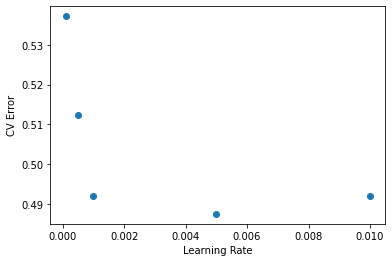

Min Learning Rate: 0.005


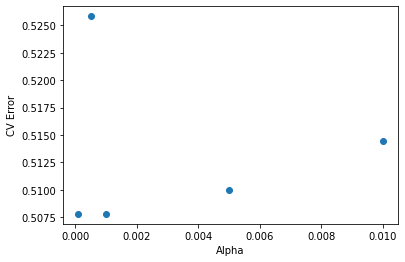

Min Alpha: 0.001


In [ ]:
import matplotlib.pyplot as plt
plt.plot(learning_rate_list, lrError, 'o')
plt.xlabel('Learning Rate')
plt.ylabel('CV Error')
plt.show()

print(f"Min Learning Rate: {learning_rate_list[np.argmin(lrError)]}")

plt.plot(learning_rate_list, alphaError, 'o')
plt.xlabel('Alpha')
plt.ylabel('CV Error')
plt.show()
print(f"Min Alpha: {alpha_list[np.argmin(alphaError)]}")

**Train and Evaluate Final Model (PCA)**

In [ ]:
#############################
#    Define NN structure    #
#############################
#   - hidden_layer_sizes = tuple, element represents the number of neurons in the ith hidden layer
#   - activation = activation function for the hidden layer | options we are interested in are {'relu', 'logistic', 'tanh'}
#   - solver = solver for weight optimization | options are {'lbfgs', 'sgd', 'adam'}, sgd is stochastic gradient descent. Apparently for small datasets lbfgs works best
#   - alpha = regularization parameter, default = .0001
#   - learning_rate = learning rate schedule for weight updates | options are {'constant', 'invscaling', 'adaptive'}
#   - learning_rate_init = initial learning rate used | only used for 'sgd' and 'adam' optimizers
#   - max_iter = maximum number of training iterations, unless earlier convergence
#   - momentum = Momentum for SGD update, only used for 'sgd' optimizer, default=.9

sectorClassifierPCA = MLPClassifier(hidden_layer_sizes=(50, 50), activation='tanh', solver='adam', alpha=.001, learning_rate='constant', learning_rate_init=.005, max_iter=100)

sectorClassifierPCA.fit(X_train, y_train)
print("Training set score: %f" % sectorClassifierPCA.score(X_train, y_train))
print("Test set score: %f" % sectorClassifierPCA.score(X_test, y_test))


Training set score: 1.000000
Test set score: 0.636364


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


**Analyze Incorrect Classifications**


Abbott Laboratories
Predicted Sector: Technology (2)
Actual Sector: Healthcare (1)


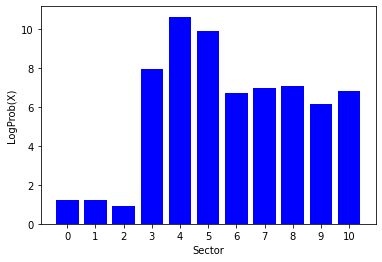

AbbVie Inc.
Predicted Sector: Technology (2)
Actual Sector: Healthcare (1)


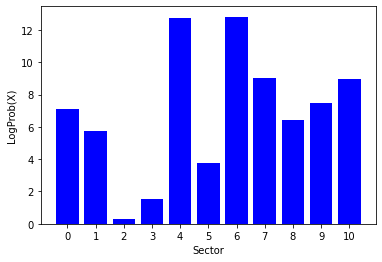

Advance Auto Parts
Predicted Sector: Healthcare (1)
Actual Sector: Consumer Cyclical (3)


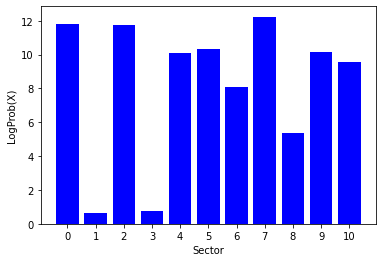

Air Products & Chemicals Inc
Predicted Sector: Technology (2)
Actual Sector: Basic Materials (6)


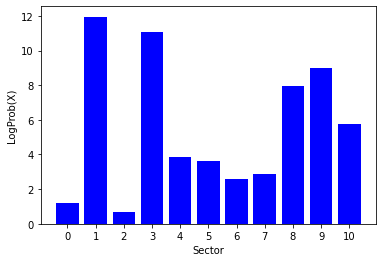

Albemarle Corp
Predicted Sector: Industrials (0)
Actual Sector: Basic Materials (6)


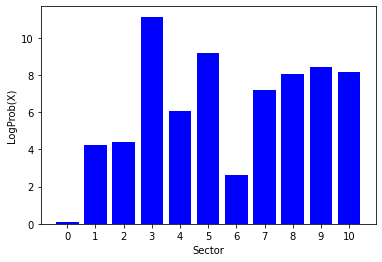

Altria Group Inc
Predicted Sector: Consumer Cyclical (3)
Actual Sector: Consumer Defensive (8)


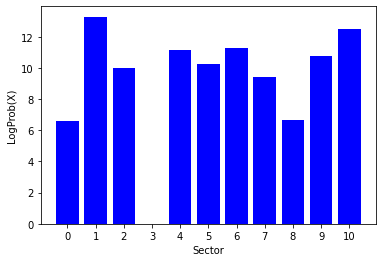

American Tower Corp A
Predicted Sector: Real Estate (7)
Actual Sector: Communication Services (9)


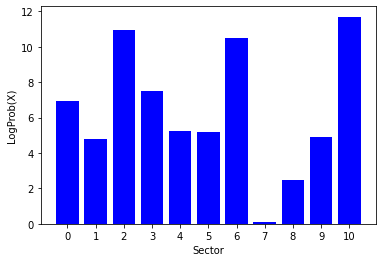

AT&T Inc
Predicted Sector: Financial Services (5)
Actual Sector: Communication Services (9)


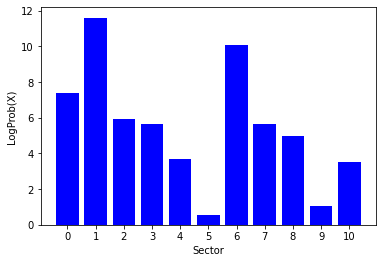

In [ ]:
for i in range(len(y_test)):
  prediction = sectorClassifierPCA.predict([X_test.iloc[i]])[0]
  log_probs = sectorClassifierPCA.predict_log_proba([X_test.iloc[i]])
  true_sector = y_test[i]
  if prediction != true_sector:
    print(f"{y_labels.iloc[i].Name}")
    print(f"Predicted Sector: {sector_map_reverse[prediction]} ({prediction})")
    print(f"Actual Sector: {sector_map_reverse[true_sector]} ({true_sector})")
    plt.bar(range(len(sector_map.items())), -1*log_probs[0], color='blue')
    plt.xticks(range(len(sector_map.items())))
    plt.xlabel('Sector')
    plt.ylabel('LogProb(X)')
    plt.show()
